In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import numpy as np

In [2]:
import pm4py

In [3]:
log = pm4py.read_xes('BPI_Challenge_2012.xes')
df = pm4py.convert_to_dataframe(log)

c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\pm4py\util\dt_parsing\parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 13087/13087 [00:08<00:00, 1603.36it/s]


In [4]:
# translating the Dutch phrases in the 'concept:name' column to English
translation_dict = {
    'W_Completeren aanvraag': 'W_Complete request',
    'W_Nabellen offertes': 'W_Follow up quotes',
    'W_Nabellen incomplete dossiers': 'W_Follow up incomplete files',
    'W_Valideren aanvraag': 'W_Validate request',
    'W_Afhandelen leads': 'W_Handle leads',
    'A_SUBMITTED': 'A_SUBMITTED',
    'A_PARTLYSUBMITTED': 'A_PARTLYSUBMITTED',
    'A_DECLINED': 'A_DECLINED',
    'A_PREACCEPTED': 'A_PREACCEPTED',
    'O_SENT': 'O_SENT',
    'O_CREATED': 'O_CREATED',
    'O_SELECTED': 'O_SELECTED',
    'A_ACCEPTED': 'A_ACCEPTED',
    'A_FINALIZED': 'A_FINALIZED',
    'O_CANCELLED': 'O_CANCELLED',
    'O_SENT_BACK': 'O_SENT_BACK',
    'A_CANCELLED': 'O_CANCELLED',
    'A_REGISTERED': 'A_REGISTERED',
    'A_ACTIVATED': 'A_ACTIVATED',
    'A_APPROVED': 'A_APPROVED',
    'O_ACCEPTED': 'O_ACCEPTED',
    'O_DECLINED': 'O_DECLINED',
    'W_Beoordelen fraude': 'W_Evaluate fraud',
    'W_Wijzigen contractgegevens': 'W_Modify contract details'
}

In [5]:
df['concept:name_eng'] = df['concept:name'].map(translation_dict)

In [6]:
# adding position to the dataframe
df['position'] = df.groupby('case:concept:name').cumcount() + 1

In [7]:
# Adding the next activity(concept:name) to the dataframe and if the next activity is not available, then it will be fill in with No_Activity
df['next_activity'] = df.groupby('case:concept:name')['concept:name'].shift(-1).fillna('No_Activity')

In [8]:
df.drop(['case:REG_DATE', 'lifecycle:transition'], axis=1, inplace = True)

In [9]:
#df = pd.read_csv('baseline_df.csv')

In [10]:
date1 = pd.to_datetime(df['time:timestamp'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f%z')
date2 = pd.to_datetime(df['time:timestamp'], errors='coerce', format='%Y-%m-%d %H:%M:%S%z')
df['date'] = date1.fillna(date2)

In [11]:
df["date_milliseconds"] = (df['date'] - pd.Timestamp("1970-01-01", tz = "UTC")) // pd.Timedelta('1ms')

In [12]:
df["duration"] = df.groupby("case:concept:name")["date_milliseconds"].shift(-1) - df["date_milliseconds"]

#df["duration"] = df["duration"] / (1000 * 60 * 60)  # Convert milliseconds to hours


In [13]:
df.head(10)

,org:resource,concept:name,time:timestamp,case:concept:name,case:AMOUNT_REQ,concept:name_eng,position,next_activity,date,date_milliseconds,duration
0,112,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,173688,20000,A_SUBMITTED,1,A_PARTLYSUBMITTED,2011-10-01 00:38:44.546000+00:00,1317429524546,334.0
1,112,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,173688,20000,A_PARTLYSUBMITTED,2,A_PREACCEPTED,2011-10-01 00:38:44.880000+00:00,1317429524880,53026.0
2,112,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,173688,20000,A_PREACCEPTED,3,W_Completeren aanvraag,2011-10-01 00:39:37.906000+00:00,1317429577906,969.0
3,112,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,173688,20000,W_Complete request,4,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,1317429578875,39427562.0
4,NaN,W_Completeren aanvraag,2011-10-01 11:36:46.437000+00:00,173688,20000,W_Complete request,5,A_ACCEPTED,2011-10-01 11:36:46.437000+00:00,1317469006437,356871.0
5,10862,A_ACCEPTED,2011-10-01 11:42:43.308000+00:00,173688,20000,A_ACCEPTED,6,O_SELECTED,2011-10-01 11:42:43.308000+00:00,1317469363308,145935.0
6,10862,O_SELECTED,2011-10-01 11:45:09.243000+00:00,173688,20000,O_SELECTED,7,A_FINALIZED,2011-10-01 11:45:09.243000+00:00,1317469509243,0.0
7,10862,A_FINALIZED,2011-10-01 11:45:09.243000+00:00,173688,20000,A_FINALIZED,8,O_CREATED,2011-10-01 11:45:09.243000+00:00,1317469509243,1954.0
8,10862,O_CREATED,2011-10-01 11:45:11.197000+00:00,173688,20000,O_CREATED,9,O_SENT,2011-10-01 11:45:11.197000+00:00,1317469511197,183.0
9,10862,O_SENT,2011-10-01 11:45:11.380000+00:00,173688,20000,O_SENT,10,W_Nabellen offertes,2011-10-01 11:45:11.380000+00:00,1317469511380,174.0


In [14]:
# finding the average duration for each position
position_dict_time = {}
for j in range(1, 176):
    time = []
    for i in (df[df['position'] == j]).index:
        time.append(df["duration"].iloc[i])
    if len(time) > 0:
        position_dict_time[j] = sum(time)/len(time)

In [15]:
# adding the average duration to each position

df['predicted_next_timestamp_milliseconds'] = df['date_milliseconds'] + df['position'].map(lambda x: position_dict_time[x]).fillna(0)
#df["duration"] = df['position'].map(lambda x: position_dict_time[x]).fillna(0) 

In [16]:
df['predicted_next_timestamp'] = df['predicted_next_timestamp_milliseconds'].apply(lambda x: '%d' % x)

In [17]:
# convert the predicted_timestamp to datetime
df['predicted_next_timestamp'] = pd.to_datetime(df['predicted_next_timestamp'], unit='ms')

C:\Users\Aahaan\AppData\Local\Temp\ipykernel_7204\1815087631.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['predicted_next_timestamp'] = pd.to_datetime(df['predicted_next_timestamp'], unit='ms')


In [18]:
df['next_timestamp'] = df.groupby('case:concept:name')['time:timestamp'].shift(-1).fillna(0)
df['next_timestamp_milliseconds'] = df.groupby('case:concept:name')['date_milliseconds'].shift(-1).fillna(0)

In [19]:
df['next_timestamp_milliseconds'] = df['next_timestamp_milliseconds'].apply(lambda x: '%d' % x)
df['predicted_next_timestamp_milliseconds'] = df['predicted_next_timestamp_milliseconds'].apply(lambda x: '%d' % x)

In [20]:
df["time_since_start"] = df.groupby('case:concept:name')["duration"].cumsum().shift(1).fillna(0)

df["time_since_start"] = df["time_since_start"] / (1000*60*60)

In [21]:
df["duration"] = df["duration"].fillna(0)

In [22]:
df["date_hours"] = df["date_milliseconds"] / (1000*60*60)

In [24]:
def nearest_upper_multiple(x, z = 24):
    # Calculate the remainder when x is divided by z
    remainder = x % z
    
    # If remainder is zero, x is already a multiple of z
    if remainder == 0:
        return x
    
    # Otherwise, calculate the nearest upper multiple
    return x + z - remainder

df["nearest_midnight"] = df["date_hours"].apply(lambda x: nearest_upper_multiple(x))

In [25]:
df["time_until_midnight"] = df["nearest_midnight"] - df["date_hours"]

In [26]:
df["hours_of_the_day"] = 24 - df["time_until_midnight"]

In [27]:
df["month"] = df["date"].dt.month

In [28]:
month_conversion_dict = {1: "January",
                         2: "February",
                         3: "March",
                         4: "April",
                         5: "May",
                         6: "June",
                         7: "July",
                         8: "August",
                         9: "September",
                         10: "October",
                         11: "November",
                         12: "December"}

In [29]:
df["month_as_string"] = df["month"].map(month_conversion_dict)

In [30]:
df["day"] = df['date'].dt.dayofweek

In [31]:
day_conversion_dict = {0: "Monday",
                       1: "Tuesday",
                       2: "Wednesday",
                       3: "Thursday",
                       4: "Friday",
                       5: "Saturday",
                       6: "Sunday"}

In [32]:
df["day_as_string"] = df["day"].map(day_conversion_dict)

In [33]:
df["time_elapsed_since_previous_event"] = df["date_milliseconds"] - df.groupby("case:concept:name")["date_milliseconds"].shift(1)

In [34]:
df["time_elapsed_since_previous_event"] = df["time_elapsed_since_previous_event"].fillna(0)

In [35]:
df["next_timestamp_milliseconds"] = df["next_timestamp_milliseconds"].astype(float)

df["next_timestamp_hours"] = df["next_timestamp_milliseconds"] / (1000*60*60)

In [44]:
from sklearn.preprocessing import OneHotEncoder

"""

encoder = OneHotEncoder()

# Fit and transform the data to one-hot encoded format
encoded_array_month = encoder.fit_transform(df[["month_as_string"]]).toarray()

# Get the feature names from the encoder's categories_
feature_names = encoder.categories_[0]

# Create a new DataFrame with one-hot encoded columns and correct column names
df_encoded = pd.DataFrame(encoded_array, columns=feature_names)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
df = pd.concat([df, df_encoded], axis=1)"""

'\n\nencoder = OneHotEncoder()\n\n# Fit and transform the data to one-hot encoded format\nencoded_array_month = encoder.fit_transform(df[["month_as_string"]]).toarray()\n\n# Get the feature names from the encoder\'s categories_\nfeature_names = encoder.categories_[0]\n\n# Create a new DataFrame with one-hot encoded columns and correct column names\ndf_encoded = pd.DataFrame(encoded_array, columns=feature_names)\n\n# Concatenate the original DataFrame with the one-hot encoded DataFrame\ndf = pd.concat([df, df_encoded], axis=1)'

In [45]:
"""encoder = OneHotEncoder()

# Fit and transform the data to one-hot encoded format
encoded_array = encoder.fit_transform(df[["day_as_string"]]).toarray()

# Get the feature names from the encoder's categories_
feature_names = encoder.categories_[0]

# Create a new DataFrame with one-hot encoded columns and correct column names
df_encoded = pd.DataFrame(encoded_array, columns=feature_names)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
df = pd.concat([df, df_encoded], axis=1)"""

'encoder = OneHotEncoder()\n\n# Fit and transform the data to one-hot encoded format\nencoded_array = encoder.fit_transform(df[["day_as_string"]]).toarray()\n\n# Get the feature names from the encoder\'s categories_\nfeature_names = encoder.categories_[0]\n\n# Create a new DataFrame with one-hot encoded columns and correct column names\ndf_encoded = pd.DataFrame(encoded_array, columns=feature_names)\n\n# Concatenate the original DataFrame with the one-hot encoded DataFrame\ndf = pd.concat([df, df_encoded], axis=1)'

In [47]:
encoder = OneHotEncoder()

encoded_array = encoder.fit_transform(df[["concept:name"]]).toarray()


feature_names = encoder.categories_[0]


df_encoded = pd.DataFrame(encoded_array, columns=feature_names)


df = pd.concat([df, df_encoded], axis=1)

In [49]:
one_hot_encode_activity_list = list(df_encoded.columns)
linear_regression_extra_predictors_list = ["position", "time_until_midnight", "month", "day", "time_elapsed_since_previous_event", "case:AMOUNT_REQ", "time_since_start", "next_timestamp_hours", "duration"]
one_hot_encode_activity_list.extend(linear_regression_extra_predictors_list)

one_hot_encode_activity_list


df_linear_regression = df[one_hot_encode_activity_list]

In [50]:
from sklearn.model_selection import train_test_split

X = df_linear_regression[['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED',
       'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED',
       'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED',
       'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads',
       'W_Beoordelen fraude', 'W_Completeren aanvraag',
       'W_Nabellen incomplete dossiers', 'W_Nabellen offertes',
       'W_Valideren aanvraag', 'W_Wijzigen contractgegevens', 'position',
       'time_until_midnight', 'month', 'day',
       'time_elapsed_since_previous_event', 'case:AMOUNT_REQ',
       'time_since_start']]
y = df_linear_regression["next_timestamp_hours"]

extra_var = df_linear_regression[["position", 'A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED',
       'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED',
       'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED',
       'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads',
       'W_Beoordelen fraude', 'W_Completeren aanvraag',
       'W_Nabellen incomplete dossiers', 'W_Nabellen offertes',
       'W_Valideren aanvraag', 'W_Wijzigen contractgegevens']]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test, extra_var_train, extra_var_test = train_test_split(X, y, extra_var, test_size=0.2, random_state=42)


In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()


model.fit(X_train, y_train)


y_pred = model.predict(X_test)



In [52]:
results_df_main_variables = pd.DataFrame({'Position': extra_var_test["position"], 'Actual': y_test, 'Predicted': y_pred})

results_df_misc_variables = extra_var_test[['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED',
       'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED',
       'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED',
       'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads',
       'W_Beoordelen fraude', 'W_Completeren aanvraag',
       'W_Nabellen incomplete dossiers', 'W_Nabellen offertes',
       'W_Valideren aanvraag', 'W_Wijzigen contractgegevens']]


results_df = pd.concat([results_df_main_variables, results_df_misc_variables], axis = 1)

results_df[results_df["Actual"] != 0]

results_df["Predicted"] = pd.to_datetime(results_df["Predicted"], unit = "h")

results_df["Actual"] = pd.to_datetime(results_df["Actual"], unit = "h")

#decoded_df = results_df[['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED',
#       'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED',
#       'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED',
#       'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads',
#       'W_Beoordelen fraude', 'W_Completeren aanvraag',
#       'W_Nabellen incomplete dossiers', 'W_Nabellen offertes',
#       'W_Valideren aanvraag', 'W_Wijzigen contractgegevens']].idxmax(axis=1)

#decoded_df

results_df = results_df.groupby("Position")[["Predicted", "Actual"]].mean()

results_df


,Predicted,Actual
Position,,
1,2011-12-20 22:55:45.955927808,2011-12-18 14:12:23.043955200
2,2011-12-14 16:03:45.609265408,2011-12-18 17:55:06.820557824
3,2004-12-30 00:27:37.045400960,2000-12-17 14:51:00.942963072
4,2008-06-01 11:16:28.123316224,2011-12-18 10:01:05.226418944
5,2007-04-20 05:48:28.169681920,2011-12-17 07:59:19.533643776
...,...,...
168,2012-04-14 13:39:20.994905344,2012-01-17 10:10:14.067000064
169,2010-01-23 10:40:41.376525056,2012-01-17 10:54:27.964000000
170,2010-02-06 02:33:03.160704256,2012-01-17 10:54:42.892999936


<Axes: >

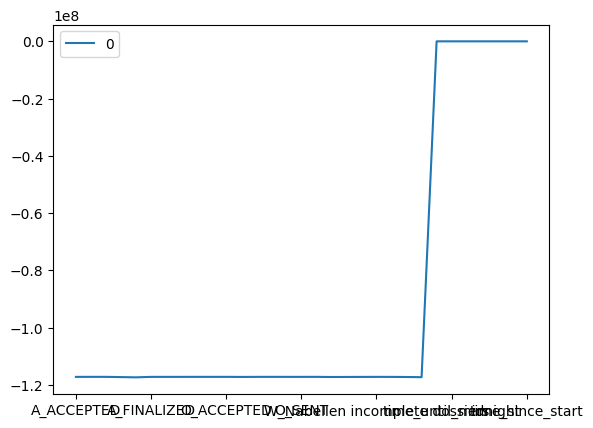

In [53]:
feature_importances = pd.Series(model.coef_, index=X.columns)

feature_importances = pd.DataFrame(feature_importances)

feature_importances.plot()

Text(0, 0.5, 'Next Timestamp')

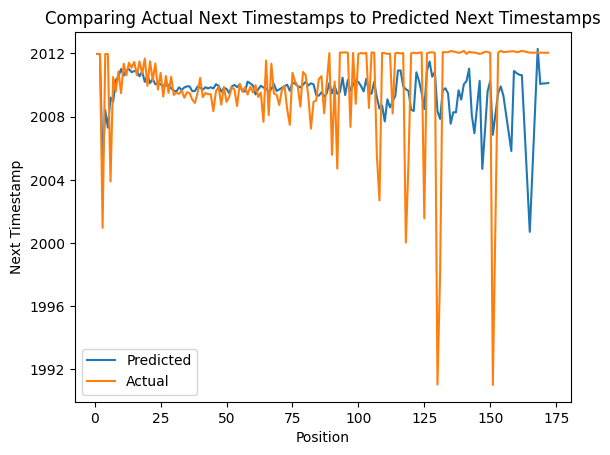

In [54]:
ax = results_df.plot(title = "Comparing Actual Next Timestamps to Predicted Next Timestamps")
ax.set_xlabel("Position")
ax.set_ylabel("Next Timestamp")


In [632]:
df.to_csv("2012_preprocessed.csv")

# The relevant code ends here

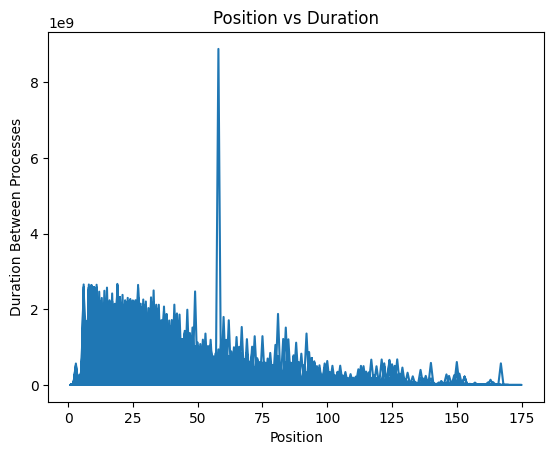

In [633]:
# Plot the time series
df.set_index("position", inplace = True)
plt.plot(df["duration"])
plt.title("Position vs Duration")
plt.xlabel("Position")
plt.ylabel("Duration Between Processes")
plt.show()
df.reset_index(inplace = True)

The plot indicates a potential time trend

In [634]:
#adf_test = adfuller(df["duration"])
# Output the results
#print('ADF Statistic: %f' % adf_test[0])
#print('p-value: %f' % adf_test[1])


In [635]:
for key, value in adf_test[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Critial Values:
   1%, -3.430374946360248
Critial Values:
   5%, -2.8615510259755492
Critial Values:
   10%, -2.566775868727863


In [636]:
print('Number of Lags Used: %f' % adf_test[2])

Number of Lags Used: 62.000000


The optimal number of lags is 62

The ADF test indicates that there is no stationarity in the data as the p-value is lower than 0.05

This also means that differencing will not be neecessary and that an ARMA model can be used instead of ARIMA

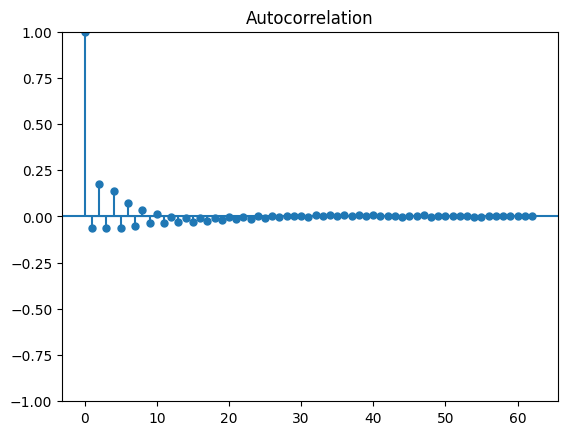

In [637]:
plot_acf(df["duration"], lags=62)
plt.show()

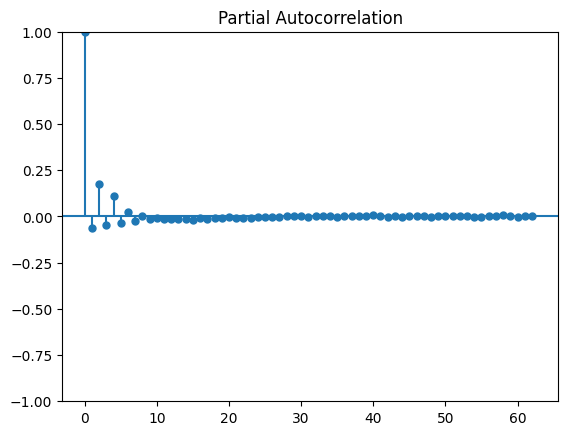

In [638]:
plot_pacf(df["duration"], lags=62)
plt.show()

In [639]:
# Fit the ARIMA(1,0,1) model

model = ARIMA(df["duration"], order=(1, 0, 1))
model_fit = model.fit()

In [640]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               duration   No. Observations:               262200
Model:                 ARIMA(1, 0, 1)   Log Likelihood            -5296512.432
Date:                Fri, 22 Mar 2024   AIC                       10593032.864
Time:                        21:09:34   BIC                       10593074.771
Sample:                             0   HQIC                      10593045.055
                             - 262200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.718e+07   2.34e-11   1.59e+18      0.000    3.72e+07    3.72e+07
ar.L1         -0.8811      0.004   -245.483      0.000      -0.888      -0.874
ma.L1          0.7905      0.004    175.785      0.0

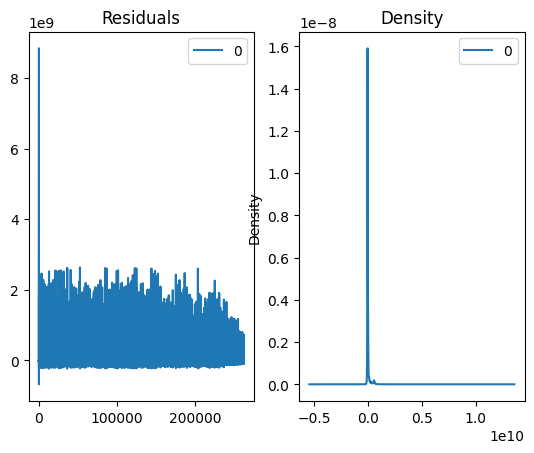

In [641]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [642]:
predictions = model_fit.predict()

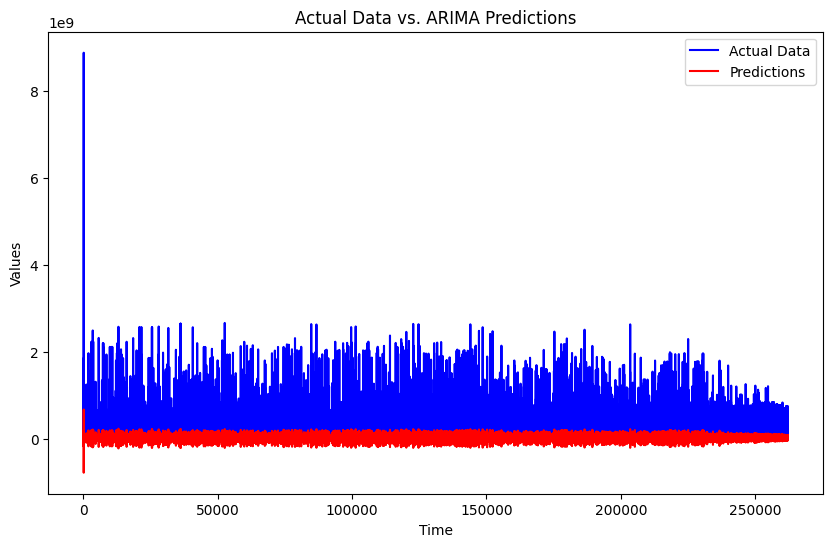

In [643]:
plt.figure(figsize=(10, 6))
plt.plot(df["duration"], label='Actual Data', color='blue')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual Data vs. ARIMA Predictions')
plt.legend()
plt.show()

In [644]:
len(df)*0.8

209760.0

In [645]:
# Indicates the training data should end at position 33

x = pd.DataFrame(df.groupby(df.index)["duration"].count())

x.iloc[0:33]["duration"].sum()

33

In [646]:
# Split the dataset into training and testing data

filtered_df = df[(df.index >= 0) & (df.index <= 33)]
filtered_df_2 = df[(df.index > 33)]

train = pd.DataFrame(filtered_df["duration"])
test = pd.DataFrame(filtered_df_2["duration"])

In [647]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 0, 1))  
fitted = model.fit()

# Training prediction
predictions = fitted.predict()

# Forecast
forecast = fitted.forecast(steps=len(test), index = test.index)



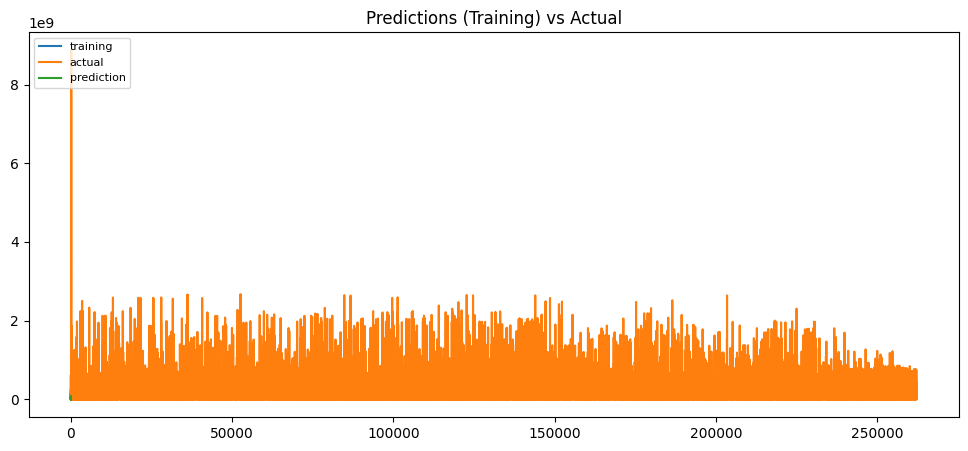

In [648]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(predictions, label='prediction')
plt.title('Predictions (Training) vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

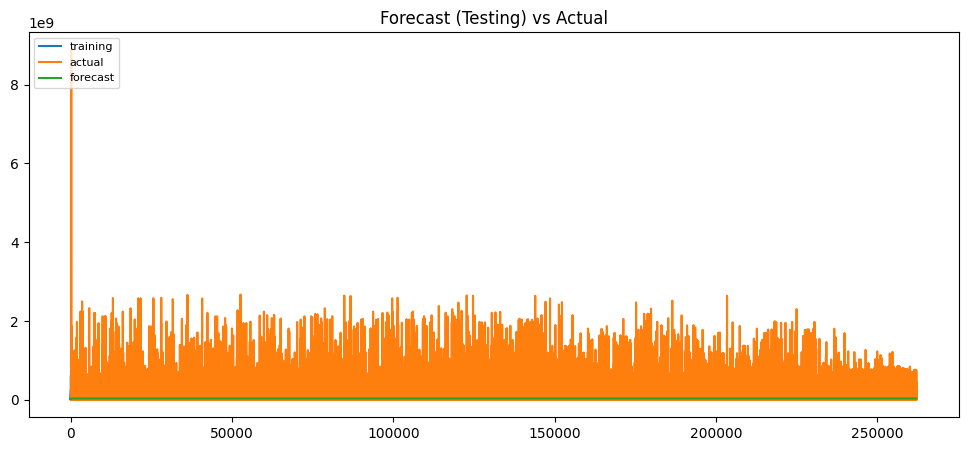

In [649]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast, label='forecast')
plt.title('Forecast (Testing) vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [650]:
#  Automatically evaluates the best model based on the AIC

# Caution the code takes about 10 minutes to execute

#from statsmodels.tsa.arima_model import ARIMA
#import pmdarima as pm

#model = pm.auto_arima(df["duration"], start_p=1, start_q=1,
#                      test='adf',       # use adftest to find optimal 'd'
#                      max_p=3, max_q=3, # maximum p and q
#                      m=1,              # frequency of series
#                      d=None,           # let model determine 'd'
#                      seasonal=False,   # No Seasonality
#                      start_P=0, 
#                      D=0, 
#                      trace=True,
#                      error_action='ignore',  
#                      suppress_warnings=True, 
#                      stepwise=True)

#print(model.summary())

In [651]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

mse_test = mean_squared_error(test, forecast)
mape_test = mean_absolute_percentage_error(test, forecast)

print("The mean squared error is: %f" %mse_test)
print("The mean absolute percentage error is: %f" %mape_test)

The mean squared error is: 21347287851717812.000000
The mean absolute percentage error is: 14993101027316110196736.000000


In [652]:
# Evaluating variance
##variance = np.var(forecast)

# Evaluating SSE
#SSE = np.mean((np.mean(forecast) - test)** 2)  
  # O/P : 85.03300391390214

# Evaluating Variance
#bias = SSE - variance
  # O/P : 28.482148757577583

#print(variance)
#print(SSE)
#print(bias)

In [653]:
#from arch import arch_model

# Define model
##model = arch_model(train, mean='Zero', vol='ARCH', p=15)
# Fit model
##model_fit = model.fit()
# Forecast the test set
#yhat = model_fit.forecast(horizon=n_test)




In [654]:
#import pm4py

#if __name__ == "__main__":
#    log = pm4py.read_xes('BPI_Challenge_2012.xes')


In [655]:
#map = pm4py.discover_heuristics_net(log)
#pm4py.view_heuristics_net(map)

In [656]:
#df

In [657]:
#from sklearn.preprocessing import OneHotEncoder

#enc = OneHotEncoder(handle_unknown='ignore')

#enc.fit(df[["concept:name"]])

#array = enc.transform(df[["concept:name"]]).toarray()

#df_one_hot = pd.DataFrame(array, columns = enc.get_feature_names_out())

In [658]:
#df = df.merge(df_one_hot, left_index = True, right_index = True)
#df

In [659]:
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error

#X = df[[enc.get_feature_names_out()]]
#y = df["Duration"]




In [660]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
#model = LinearRegression()
#model.fit(X_train, y_train)

# Make predictions on the testing set
#y_pred = model.predict(X_test)

# Evaluate model
#mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)

In [661]:
#import duckdb

In [662]:
#df

In [663]:
df_time_series = df.groupby("position")[["duration"]].mean()

In [664]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# Define ARIMA parameters
p = 1  # AR order
d = 0  # Integrated order (differencing)
q = 1  # MA order

# Initialize TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)



def evaluate_arima_model(train, test, order):
    history = list(train["duration"])
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t]["duration"])
    error = mean_absolute_error(test["duration"], predictions)
    return error

# Perform k-fold cross-validation with ARIMA model using MAE
errors = []
for train_idx, test_idx in tscv.split(df_time_series):
    train, test = df_time_series.iloc[train_idx], df_time_series.iloc[test_idx]
    error = evaluate_arima_model(train, test, order=(p, d, q))
    errors.append(error)

# Calculate mean absolute error across folds
mean_error = np.mean(errors)
print("Mean Absolute Error (MAE):", mean_error)

c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Mean Absolute Error (MAE): 14442587.40742222


In [665]:
mean_mae_hours = mean_error / (1000*60*60)
mean_mae_hours

4.011829835395061

<Axes: xlabel='position'>

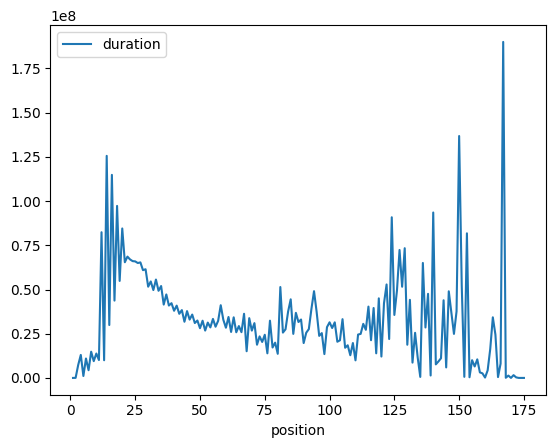

In [666]:
df_time_series.plot()

In [667]:
"""

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error


# Define ARIMA parameters
p = 1  # AR order
d = 0  # Integrated order (differencing)
q = 1  # MA order

# Initialize TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Initialize dictionary to store MAE for each variable combination
mae_dict = {}

# Define a function to evaluate ARIMA model using cross-validation with MAE
def evaluate_arima_model(train, test, order, variables):
    history = list(train["duration"])
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t]["duration"])
    error = mean_absolute_error(test["duration"], predictions)
    mae_dict[tuple(variables)] = mae_dict.get(tuple(variables), []) + [error]
    return error

# Perform k-fold cross-validation with ARIMA model using MAE for different feature combinations
for train_idx, test_idx in tscv.split(df):
    train, test = df.iloc[train_idx], df.iloc[test_idx]
    # Generate all possible feature combinations
    features = df.columns.drop(['date',])  # Exclude date and target value columns
    for r in range(1, len(features) + 1):
        for combo in combinations(features, r):
            error = evaluate_arima_model(train, test, order=(p, d, q), variables=combo)

# Calculate mean MAE for each feature combination
mean_mae_dict = {variables: np.mean(errors) for variables, errors in mae_dict.items()}
print("Mean Absolute Error (MAE) for each feature combination:")
for variables, mean_mae in mean_mae_dict.items():
    print(f"Variables: {variables}, Mean MAE: {mean_mae}")
    
"""


'\n\nfrom sklearn.model_selection import TimeSeriesSplit\nfrom sklearn.metrics import mean_absolute_error\n\n\n# Define ARIMA parameters\np = 1  # AR order\nd = 0  # Integrated order (differencing)\nq = 1  # MA order\n\n# Initialize TimeSeriesSplit cross-validator\ntscv = TimeSeriesSplit(n_splits=5)\n\n# Initialize dictionary to store MAE for each variable combination\nmae_dict = {}\n\n# Define a function to evaluate ARIMA model using cross-validation with MAE\ndef evaluate_arima_model(train, test, order, variables):\n    history = list(train["duration"])\n    predictions = []\n    for t in range(len(test)):\n        model = ARIMA(history, order=order)\n        model_fit = model.fit()\n        yhat = model_fit.forecast()[0]\n        predictions.append(yhat)\n        history.append(test.iloc[t]["duration"])\n    error = mean_absolute_error(test["duration"], predictions)\n    mae_dict[tuple(variables)] = mae_dict.get(tuple(variables), []) + [error]\n    return error\n\n# Perform k-fold c

In [668]:
mean_mae_hours = mean_error / (1000*60*60)
mean_mae_hours

4.011829835395061

In [669]:
#log_2018 = pm4py.read_xes("BPI Challenge 2018.xes")
#df_2018 = pm4py.convert_to_dataframe(log_2018)

In [670]:
#df_2018

In [671]:
#df_time_series